## Configurations for Colab

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    !pip install gym
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

# 01. DQN

[V. Mnih et al., "Human-level control through deep reinforcement learning." Nature, 518
(7540):529–533, 2015.](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)

Reinforcement learning is known to be unstable or even to diverge when a nonlinear function approximator such as a neural network is used to represent the action-value (also known as $Q$) function. This instability has several causes: the correlations present in the sequence of observations, the fact that small updates to $Q$ may significantly change the policy and therefore change the data distribution, and the correlations between the action-values ($Q$) and the target values $r + \gamma \max_{a'} Q(s', a')$.

The authors suggest two key ideas to address these instabilities with a novel variant of Q-learning: Replay buffer and Fixed Q-target.

#### Uniformly random sampling from Experience Replay Memory

Reinforcement learning agent stores the experiences consecutively in the buffer, so adjacent ($s, a, r, s'$) transitions stored are highly likely to have correlation. To remove this, the agent samples experiences uniformly at random from the pool of stored samples $\big( (s, a, r, s') \sim U(D) \big)$. See sample_batch method of ReplayBuffer class for more details.

#### Fixed Q-target

DQN uses an iterative update that adjusts the action-values ($Q$) towards target values that are only periodically updated, thereby reducing correlations with the target; if not, it is easily divergy because the target continuously moves. The Q-learning update at iteration $i$ uses the following loss function:

$$
L_i(\theta_i) = \mathbb{E}_{(s,a,r,s') \sim U(D)} \big[ \big( r + \gamma \max_{a'} Q(s',a';\theta_i^-) - Q(s, a; \theta_i) \big)^2 \big]
$$

in which $\gamma$ is the discount factor determining the agent’s horizon, $\theta_i$ are the parameters of the Q-network at iteration $i$ and $\theta_i^-$ are the network parameters used to compute the target at iteration $i$. The target network parameters $\theta_i^-$ are only updated with the Q-network parameters ($\theta_i$) every C steps and are held fixed between individual updates. ($C = 200$ in CartPole-v0)

#### For more stability: Gradient clipping

The authors also found it helpful to clip the error term from the update $r + \gamma \max_{a'} Q(s', a'; \theta_i^-) - Q(s,a,;\theta_i)$ to be between -1 and 1. Because the absolute value loss function $|x|$ has a derivative of -1 for all negative values of x and a derivative of 1 for all positive values of x, clipping the squared error to be between -1 and 1 corresponds to using an absolute value loss function for errors outside of the (-1,1) interval. This form of error clipping further improved the stability of the algorithm.

In [2]:
import os
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

## Replay buffer

Typically, people implement replay buffers with one of the following three data structures:

  - collections.deque
  - list
  - numpy.ndarray
  
**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of  *Get item* is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference). Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.


Reference: [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)

In [3]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

## Network

We are going to use a simple network architecture with three fully connected layers and two non-linearity functions (ReLU).

In [4]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

## DQN Agent

Here is a summary of DQNAgent class.

| Method           | Note                                                 |
| ---              | ---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|compute_dqn_loss  | return dqn loss.                                     |
|update_model      | update the model by gradient descent.                |
|target_hard_update| hard update from the local model to the target model.|
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |


In [5]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
        
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state = self.env.reset()
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state = self.env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon, self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)
                
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)
                
        self.env.close()
                
    def test(self) -> List[np.ndarray]:
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """Return dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(
            next_state
        ).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        # calculate dqn loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float], 
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

## Environment

You can see the [code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) and [configurations](https://github.com/openai/gym/blob/master/gym/envs/__init__.py#L53) of CartPole-v0 from OpenAI's repository.

In [6]:
# environment
env_id = "CartPole-v0"
env = gym.make(env_id)
if IN_COLAB:
    env = gym.wrappers.Monitor(env, "videos", force=True)

## Set random seed

In [7]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)
env.seed(seed)

[777]

## Initialize

In [8]:
# parameters
num_frames = 20000
memory_size = 1000
batch_size = 32
target_update = 100
epsilon_decay = 1 / 2000

agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay)

cpu


## Train

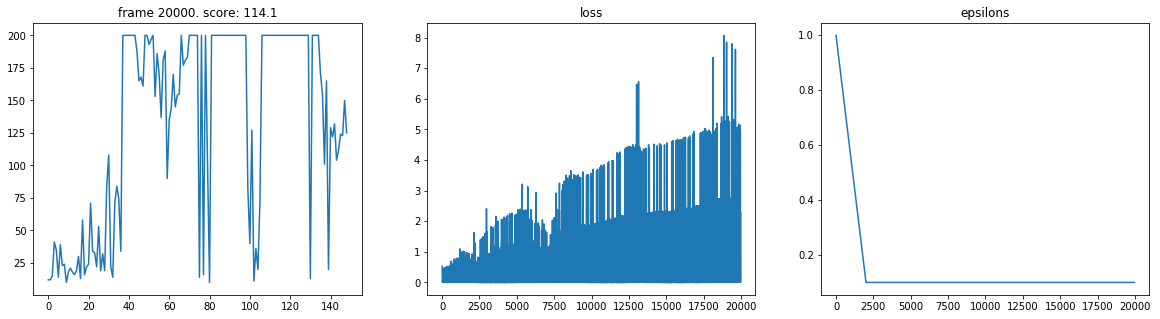

In [9]:
agent.train(num_frames)

## Test

Run the trained agent (1 episode).

In [10]:
frames = agent.test()

score:  112.0


## Render


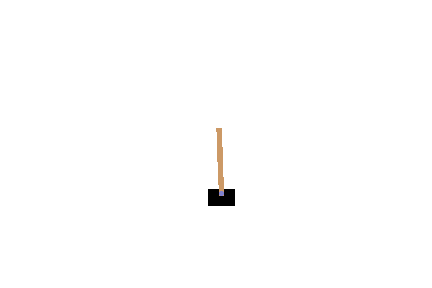
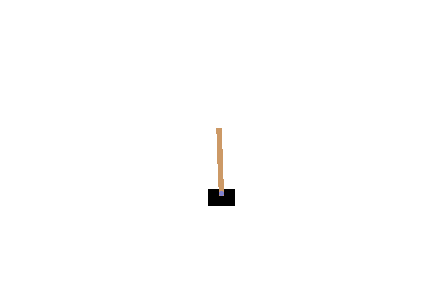
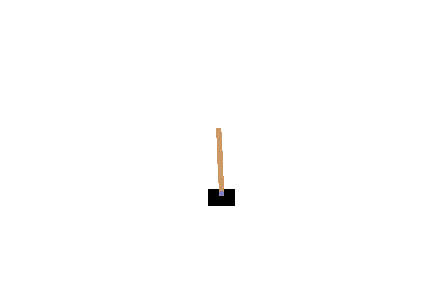
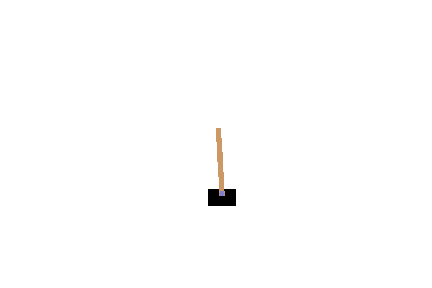
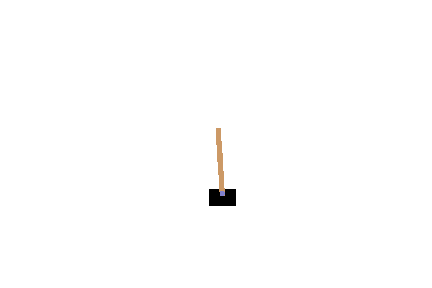
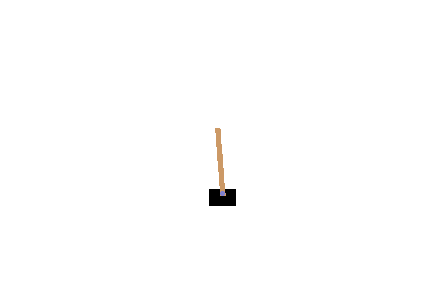
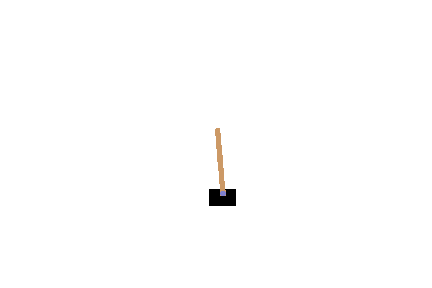
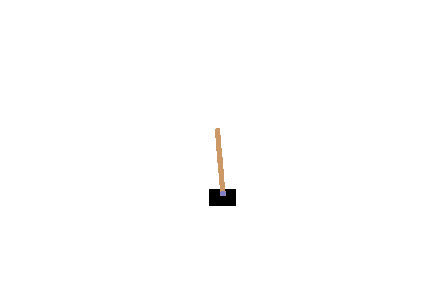
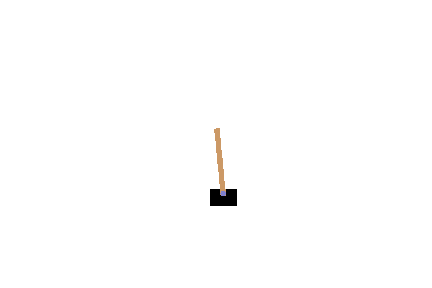
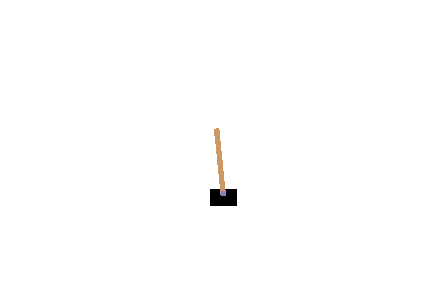
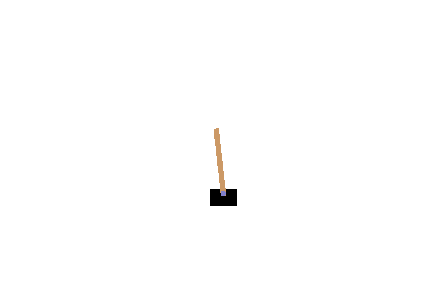
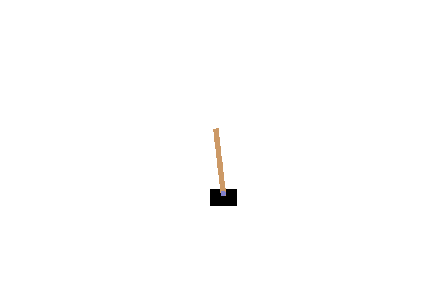
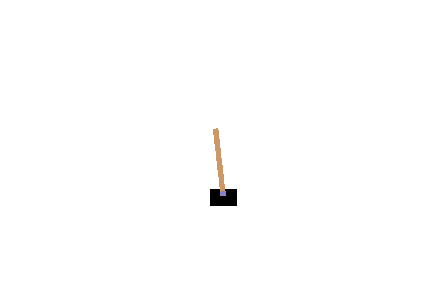
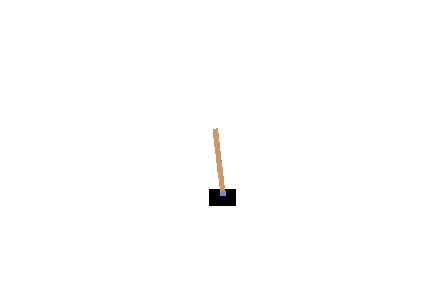
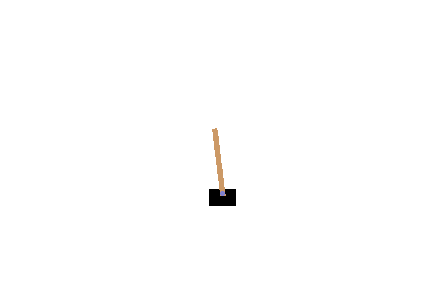
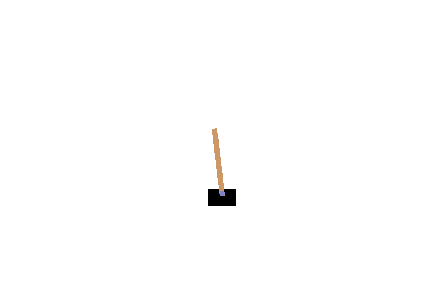
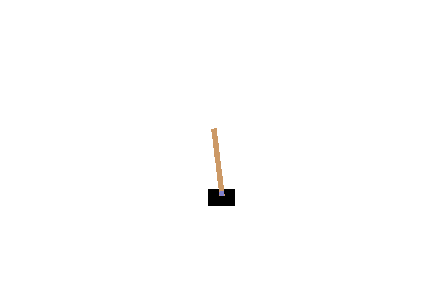
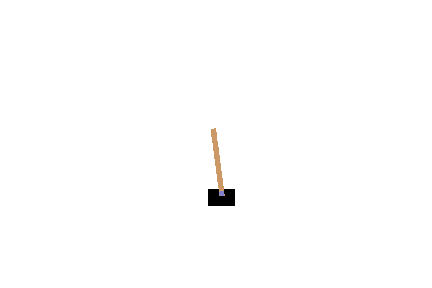
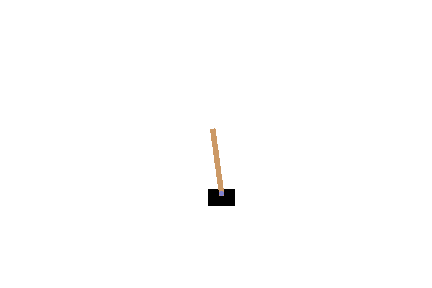
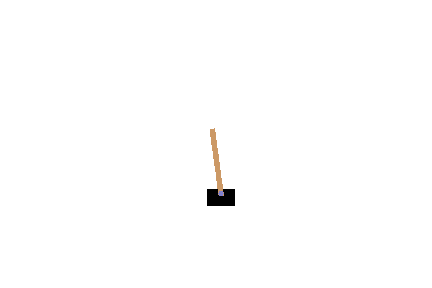
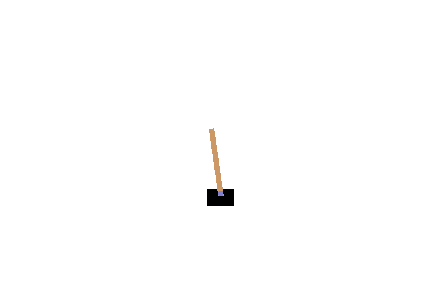
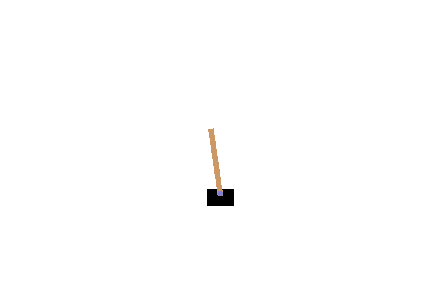
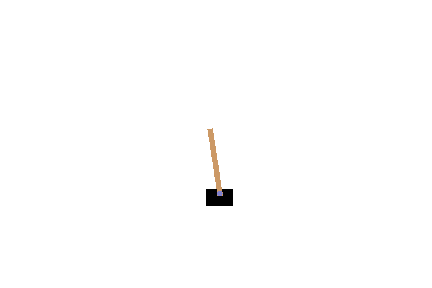
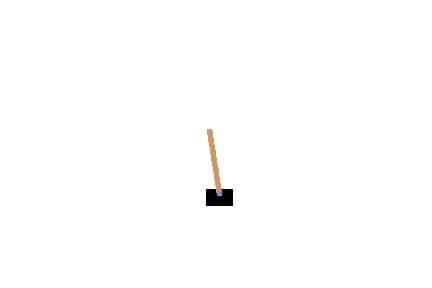
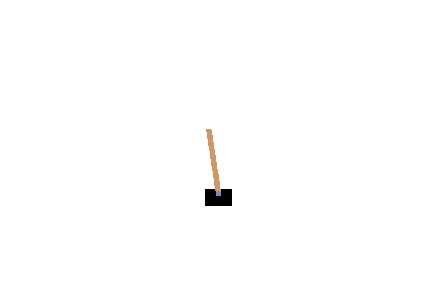
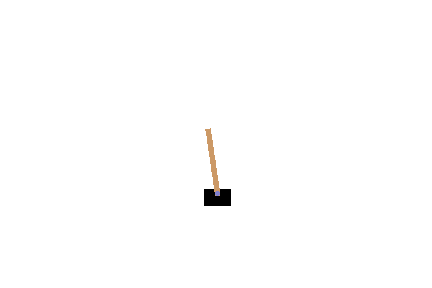
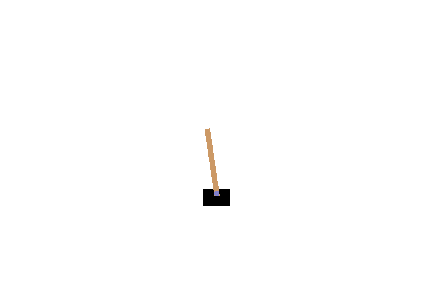
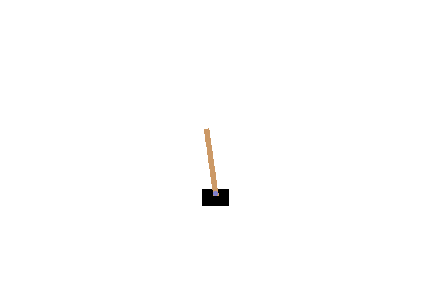
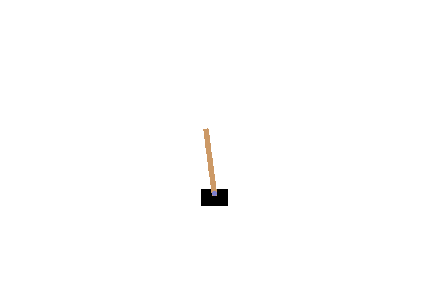
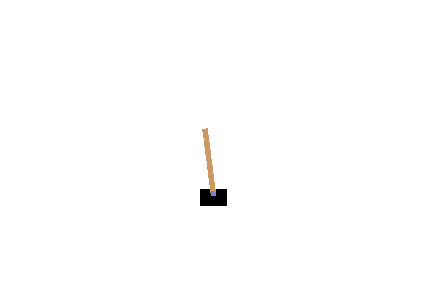
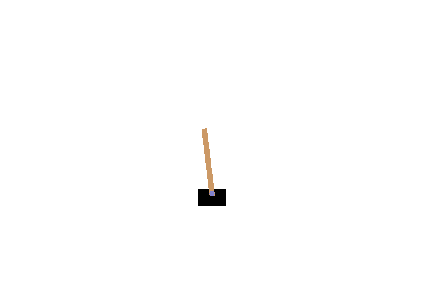
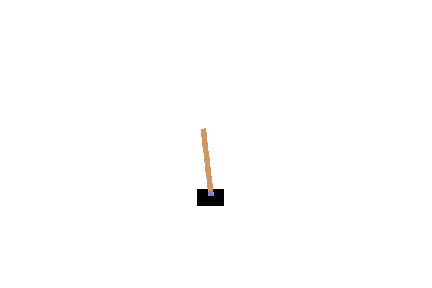
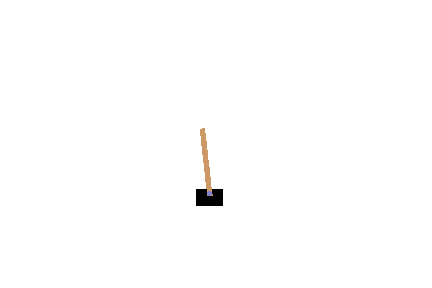
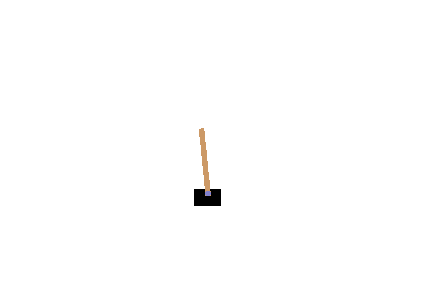
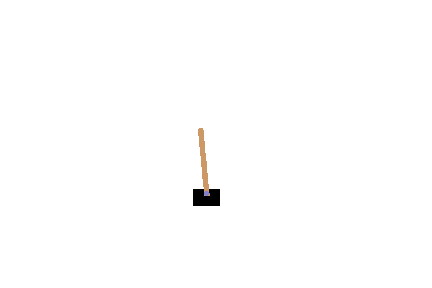
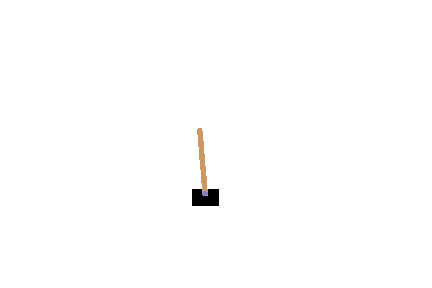
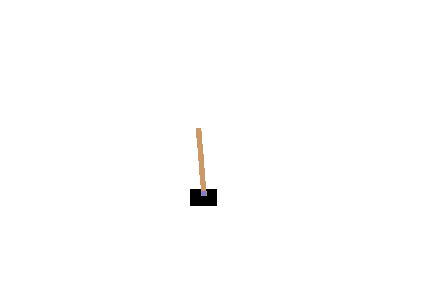
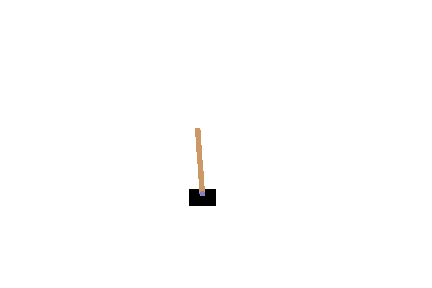
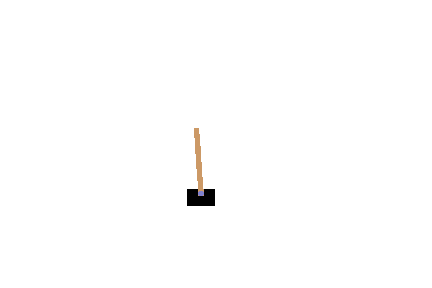
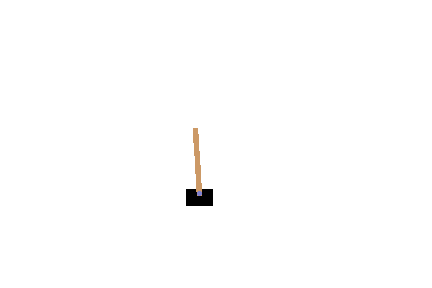
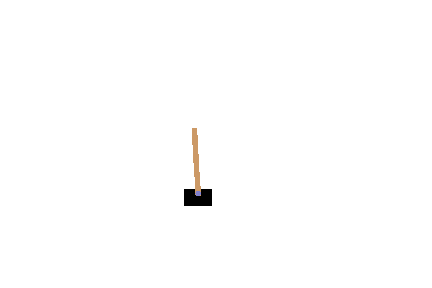
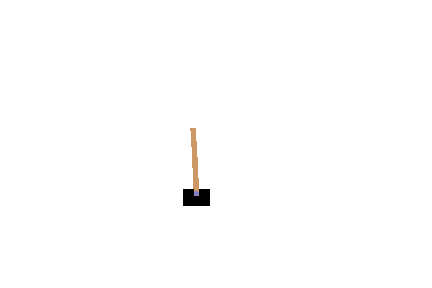
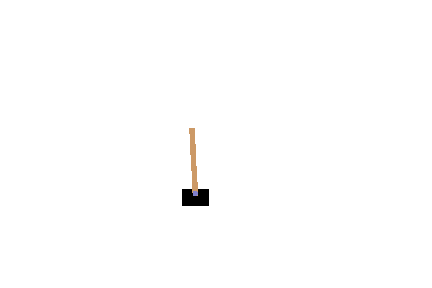
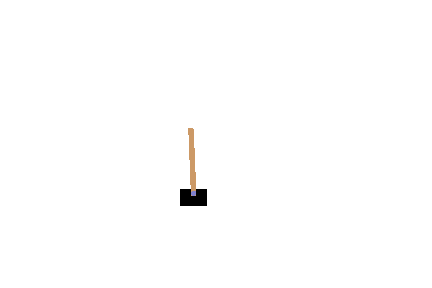
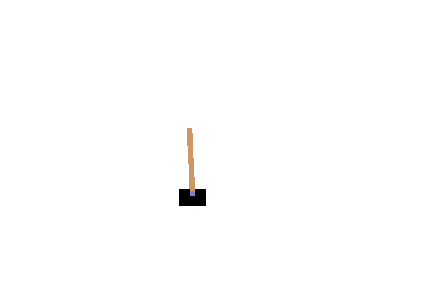
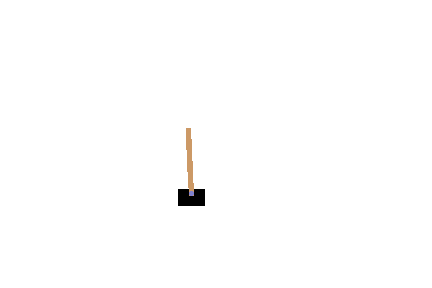
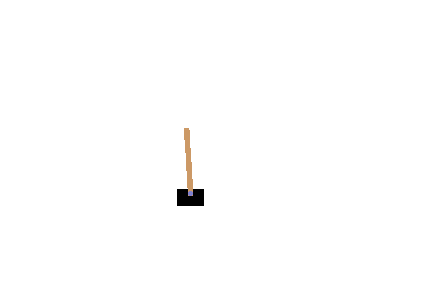
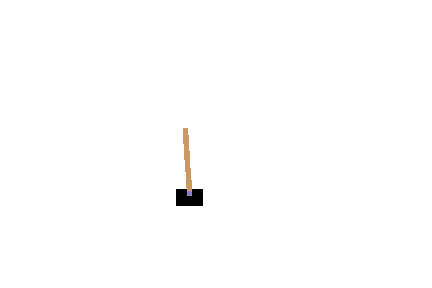
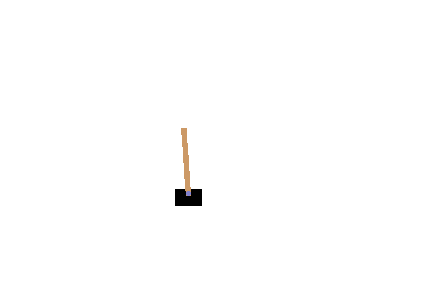
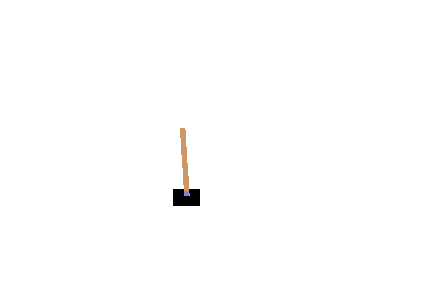
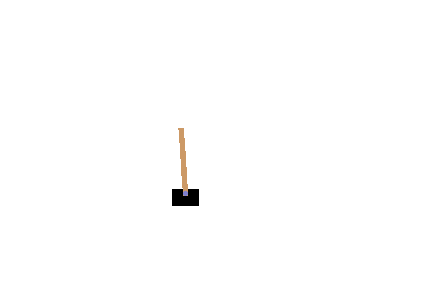
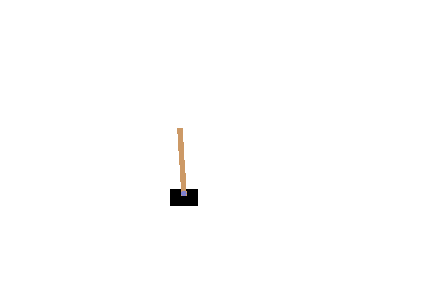
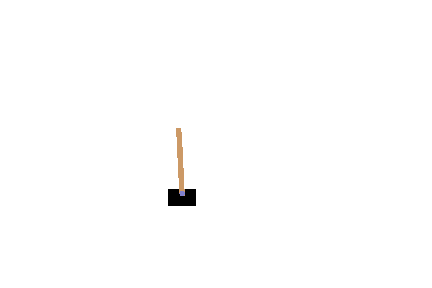
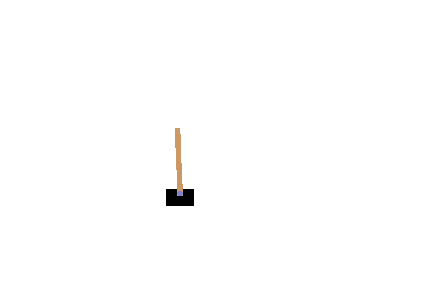
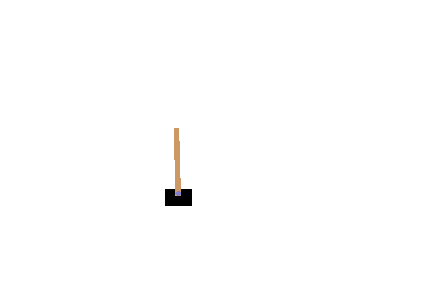
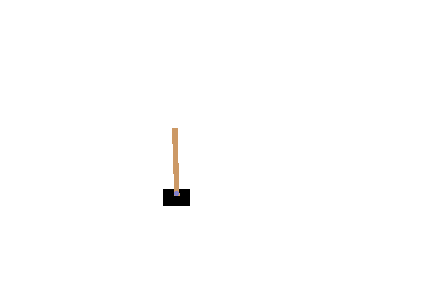
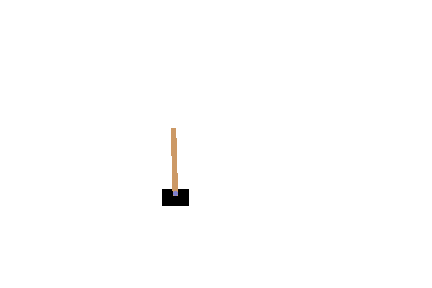
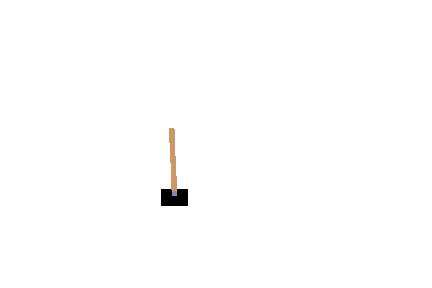
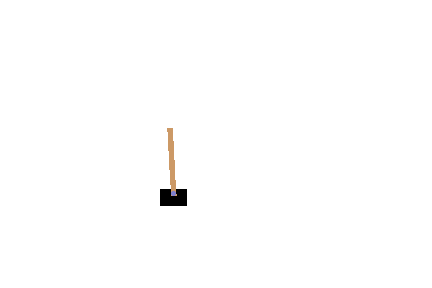
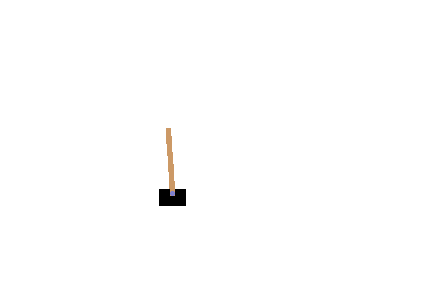
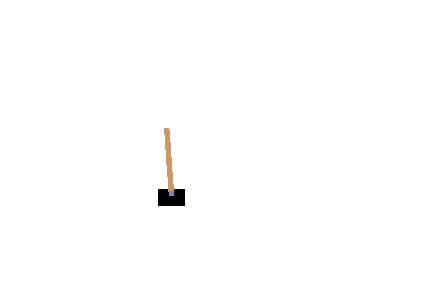
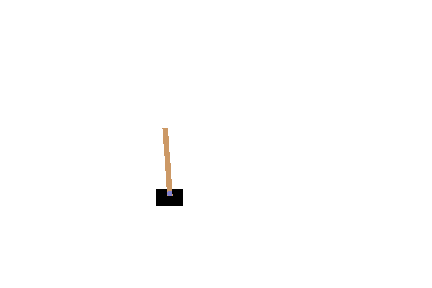
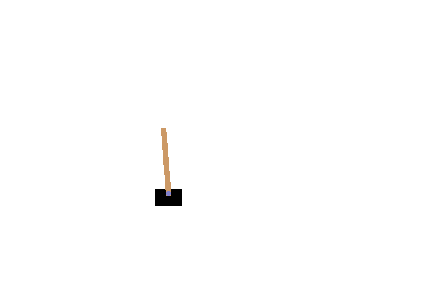
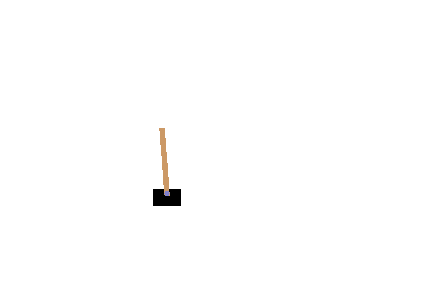
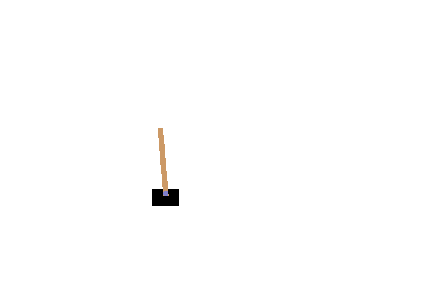
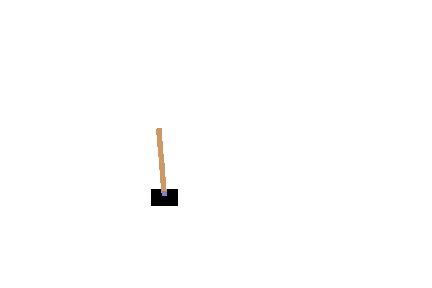
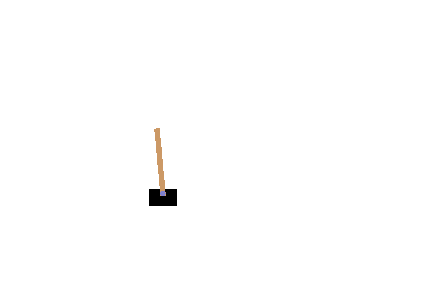
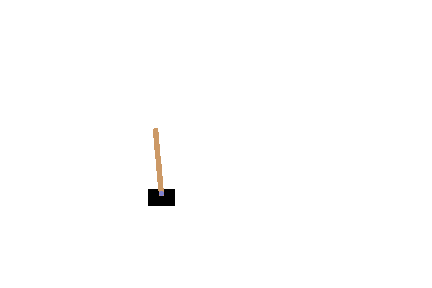
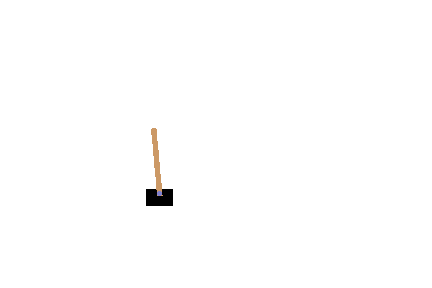
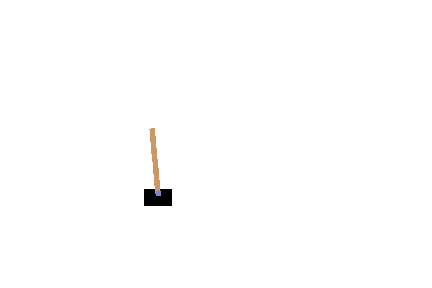
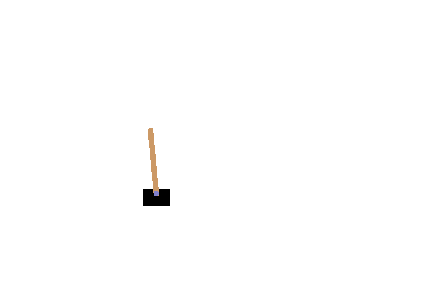
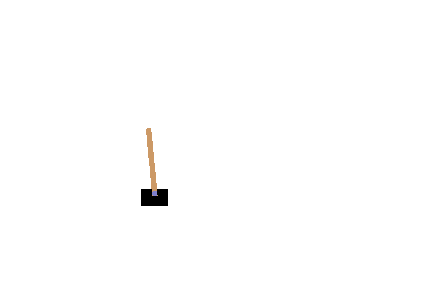
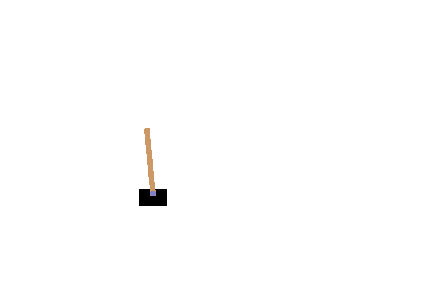
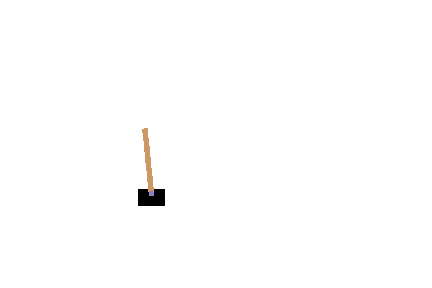
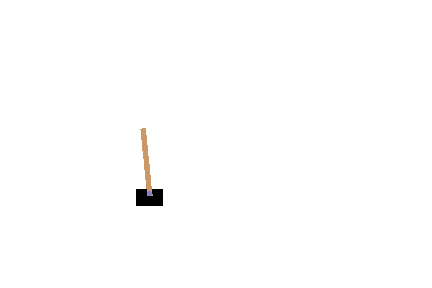
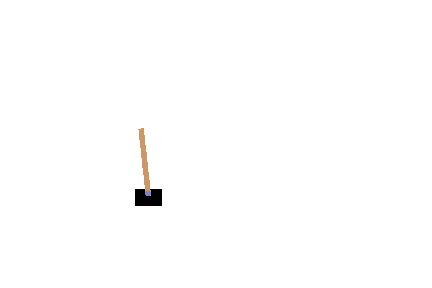
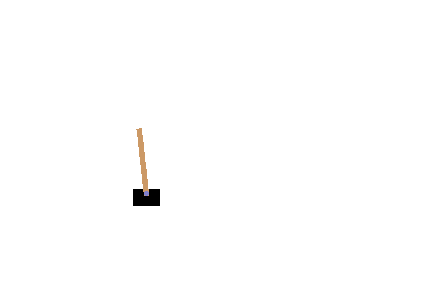
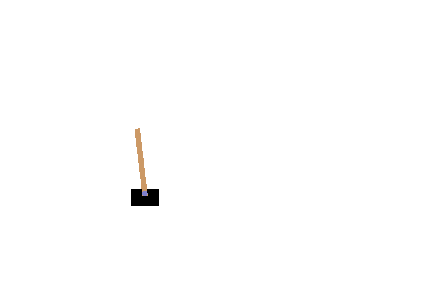
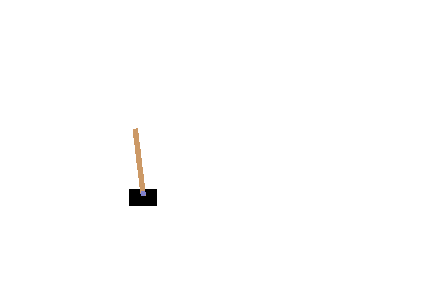
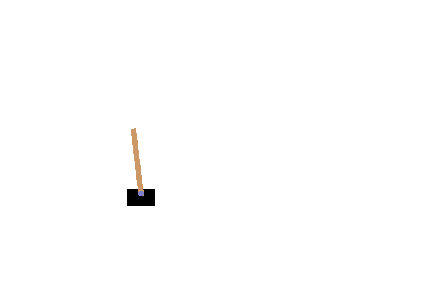
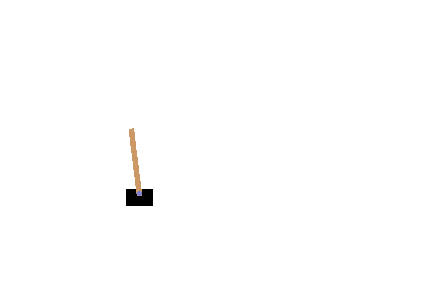
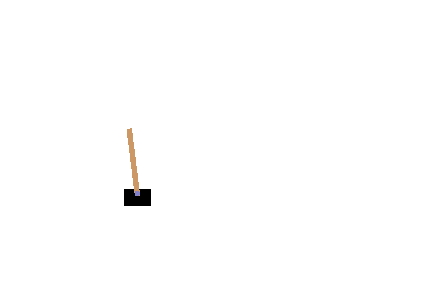
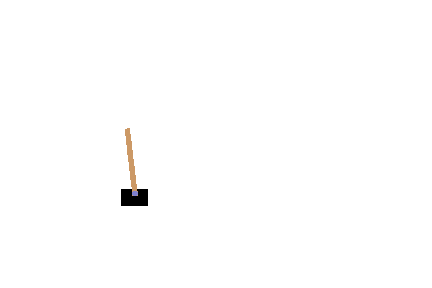
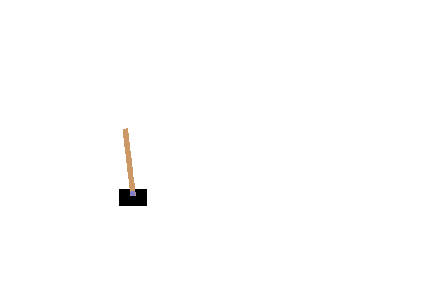
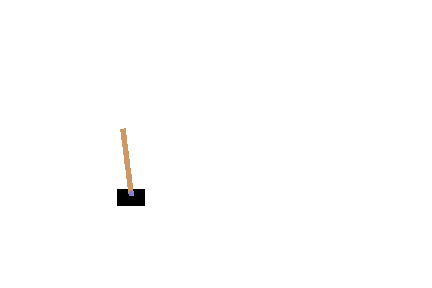
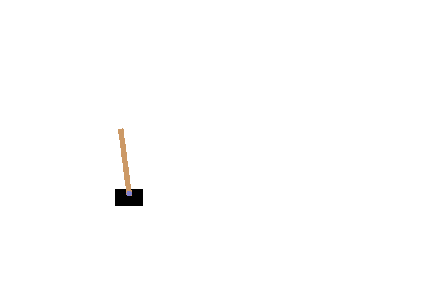
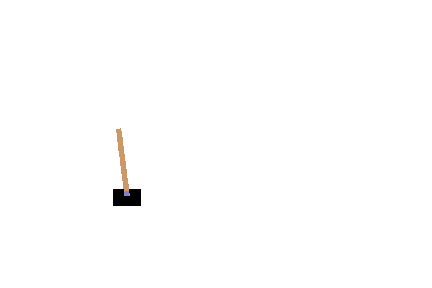
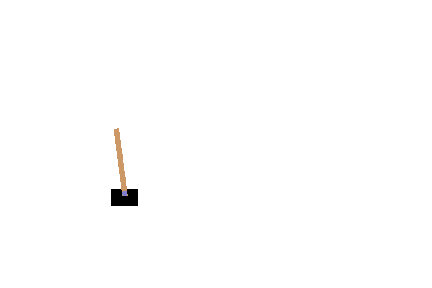
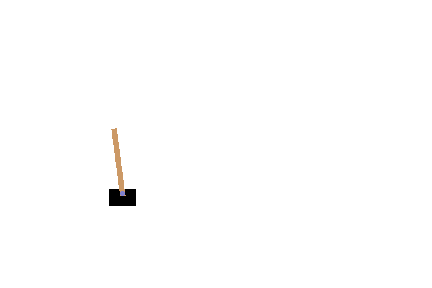
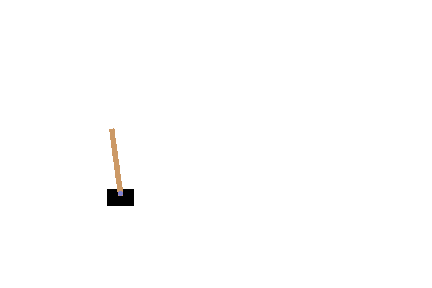
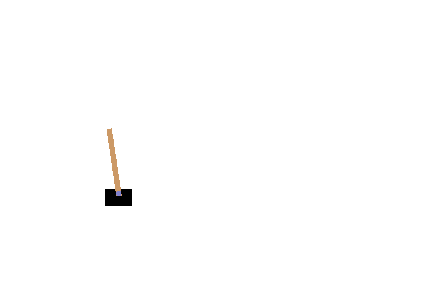
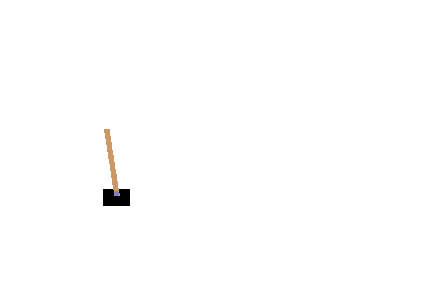
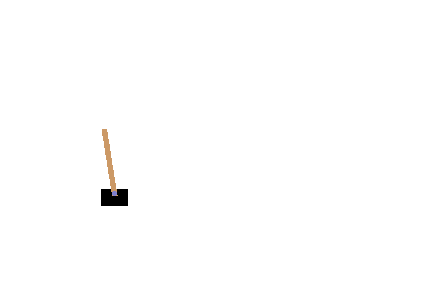
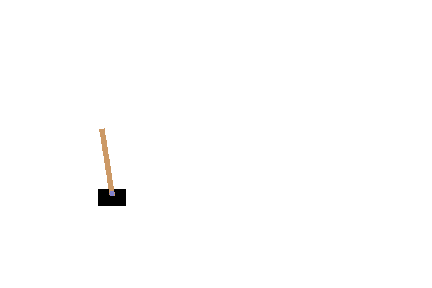
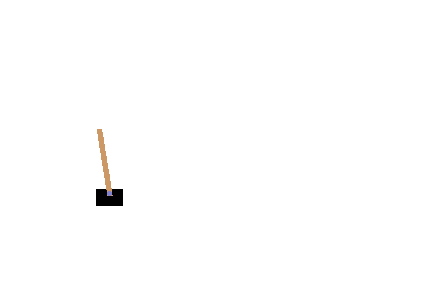
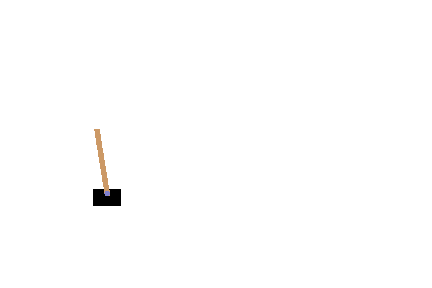
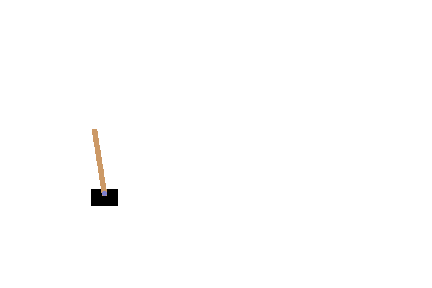
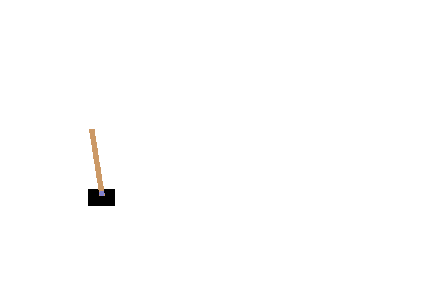
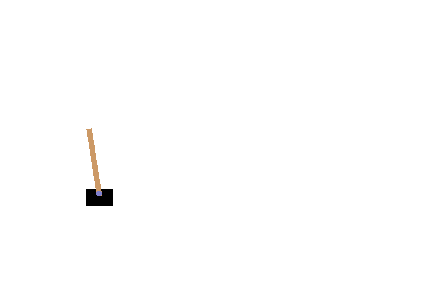
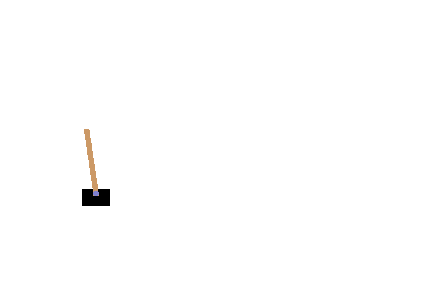
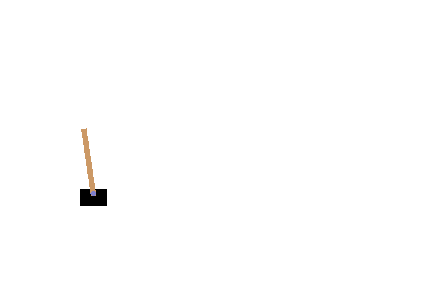
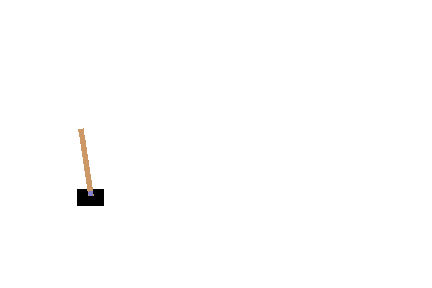
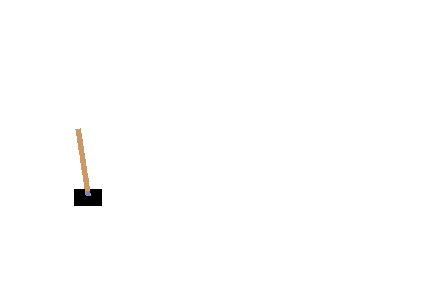
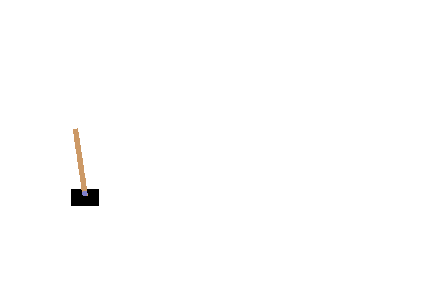
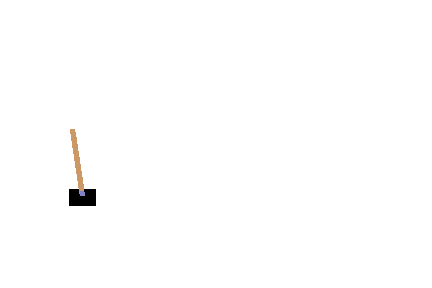
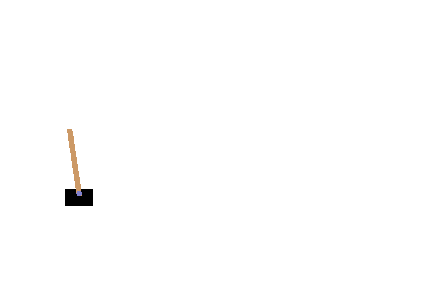
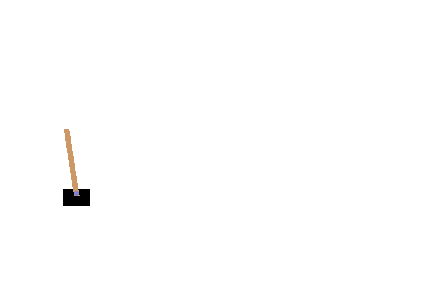
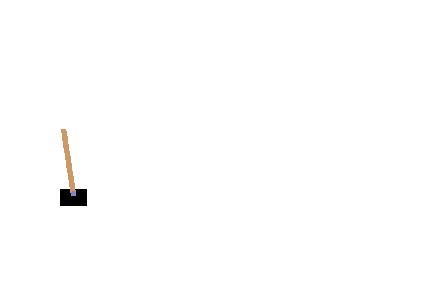
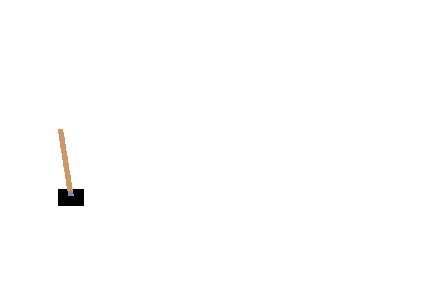
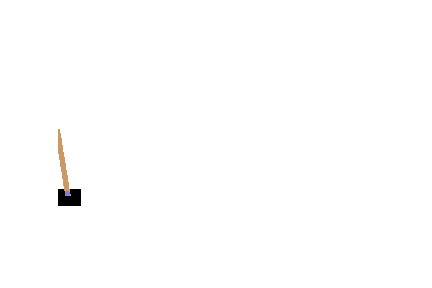
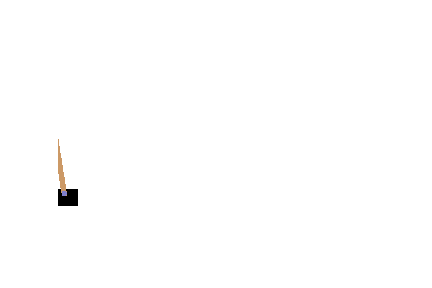
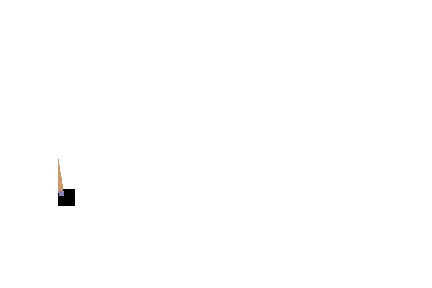

In [11]:
if IN_COLAB:  # for colab
    import base64
    import glob
    import io
    import os

    from IPython.display import HTML, display


    def ipython_show_video(path: str) -> None:
        """Show a video at `path` within IPython Notebook."""
        if not os.path.isfile(path):
            raise NameError("Cannot access: {}".format(path))

        video = io.open(path, "r+b").read()
        encoded = base64.b64encode(video)

        display(HTML(
            data="""
            <video alt="test" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
            </video>
            """.format(encoded.decode("ascii"))
        ))

    list_of_files = glob.glob("videos/*.mp4")
    latest_file = max(list_of_files, key=os.path.getctime)
    print(latest_file)
    ipython_show_video(latest_file)
    
else:  # for jupyter
    from matplotlib import animation
    from JSAnimation.IPython_display import display_animation
    from IPython.display import display


    def display_frames_as_gif(frames: List[np.ndarray]) -> None:
        """Displays a list of frames as a gif, with controls."""
        patch = plt.imshow(frames[0])
        plt.axis('off')

        def animate(i):
            patch.set_data(frames[i])

        anim = animation.FuncAnimation(
            plt.gcf(), animate, frames = len(frames), interval=50
        )
        display(display_animation(anim, default_mode='loop'))


    # display 
    display_frames_as_gif(frames)